In [1]:
pip install prophet


     -------------------------------------- 12.1/12.1 MB 636.8 kB/s eta 0:00:00
     ------------------------------------ 378.2/378.2 kB 547.6 kB/s eta 0:00:00
     ---------------------------------------- 83.2/83.2 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 870.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 342.1/342.1 kB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 2.0 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732051 sha256=422d1001bd784afed7d28321de966a268966b49e7b7c840d9b962470c6010049
  Stored in directory: c:\users\sahani\appdata\local\pip\cache\wheels\74\47\c4\678b0a3d5213e2f8500f3ea0f8dc3c81478e5b806c557dff58
Successfully built pymeeus


In [2]:
pip install pmdarima


     ------------------------------------ 569.7/569.7 kB 832.6 kB/s eta 0:00:00
     -------------------------------------- 987.3/987.3 kB 1.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from prophet import Prophet

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [12]:
data = pd.read_excel("UNRATE.xlsx", sheet_name = "Data")
df = pd.DataFrame(data=data)
df

,observation_date,UNRATE
0,2000-01-01,4.0
1,2000-02-01,4.1
2,2000-03-01,4.0
3,2000-04-01,3.8
4,2000-05-01,4.0
...,...,...
367,2030-08-01,NaN
368,2030-09-01,NaN
369,2030-10-01,NaN
370,2030-11-01,NaN


In [13]:
df.set_index("observation_date", inplace = True)
df

,UNRATE
observation_date,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0
...,...
2030-08-01,NaN
2030-09-01,NaN
2030-10-01,NaN


# Time Series Forecast

In [14]:
columns = df.columns
columns

Index(['UNRATE'], dtype='object')

In [15]:
i = 0

In [16]:
df = df.fillna(0)
df

,UNRATE
observation_date,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0
...,...
2030-08-01,0.0
2030-09-01,0.0
2030-10-01,0.0


In [25]:
j = 278

In [26]:
df[columns[i]][0:j].tail()

observation_date
2022-10-01    3.7
2022-11-01    3.6
2022-12-01    3.5
2023-01-01    3.4
2023-02-01    3.6
Name: UNRATE, dtype: float64

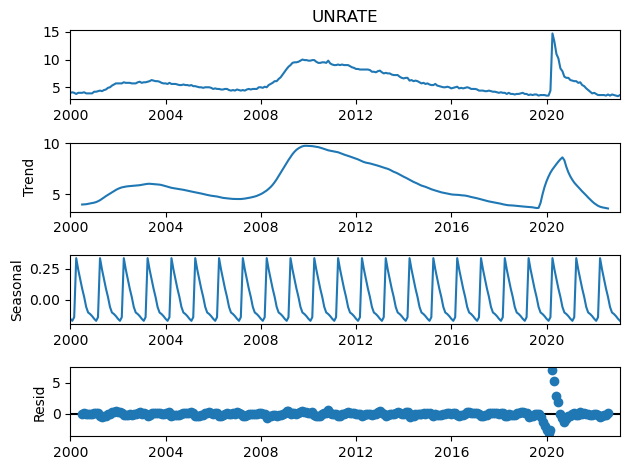

In [28]:
decomposition = seasonal_decompose(df[columns[i]][0:j], model = 'additive')
fig = decomposition.plot()
plt.show()

In [29]:
data_copy = df.copy()

# Holt Winters

In [34]:
data_copy = df.copy()

In [35]:
fitted_model = ExponentialSmoothing(data_copy[0:j][columns[i]], seasonal_periods=12, trend='add', seasonal='add',
                                    initialization_method = 'heuristic'
                                    ).fit(smoothing_level = 0.5, smoothing_slope = 0.05, smoothing_seasonal = 0.4)

C:\Users\Sahani\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Sahani\AppData\Local\Temp\ipykernel_2168\1465552888.py:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead.
  fitted_model = ExponentialSmoothing(data_copy[0:j][columns[i]], seasonal_periods=12, trend='add', seasonal='add',


<Axes: xlabel='observation_date'>

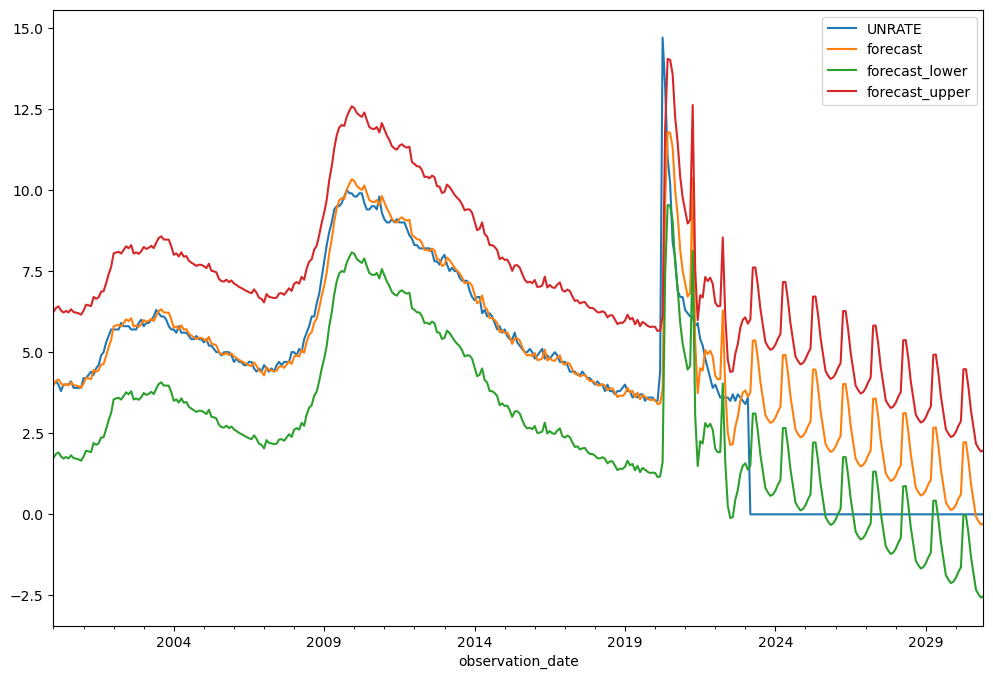

In [36]:
data_copy['forecast'] = fitted_model.predict(start=0,end=len(df))

n = j
k = 3
df_k = n - k
t_value = t.ppf(0.995, df_k)

forecast_error = np.array(fitted_model.resid)
forecast_std = np.sqrt(np.mean(np.square(forecast_error)))
data_copy['forecast_lower'] = data_copy['forecast'] - (t_value * forecast_std)
data_copy['forecast_upper'] = data_copy['forecast'] + (t_value * forecast_std)

data_copy[[columns[i], 'forecast', 'forecast_lower', 'forecast_upper']].plot(figsize=(12,8))

In [37]:
error = np.sqrt(mean_squared_error(data_copy[columns[i]][0:j], data_copy['forecast'][0:j]))
print(error)

mape = mean_absolute_error(data_copy[columns[i]][0:j], data_copy['forecast'][0:j])
print(mape)

0.8678187061871913
0.32573916688871346


In [38]:
data_copy.reset_index(inplace=True)
data_copy

,observation_date,UNRATE,forecast,forecast_lower,forecast_upper
0,2000-01-01,4.0,3.991690,1.740721,6.242660
1,2000-02-01,4.1,4.111812,1.860842,6.362782
2,2000-03-01,4.0,4.159706,1.908736,6.410676
3,2000-04-01,3.8,4.037460,1.786490,6.288430
4,2000-05-01,4.0,3.969177,1.718207,6.220147
...,...,...,...,...,...
367,2030-08-01,0.0,0.430291,-1.820679,2.681261
368,2030-09-01,0.0,-0.073353,-2.324323,2.177617
369,2030-10-01,0.0,-0.211556,-2.462526,2.039414
370,2030-11-01,0.0,-0.316343,-2.567313,1.934627


In [39]:
data_copy.to_excel("HoltWinters_Results.xlsx", index=False)

# FB Prophet

In [40]:
data = pd.read_excel("UNRATE.xlsx", sheet_name = "Data")
df = pd.DataFrame(data=data)
df

,observation_date,UNRATE
0,2000-01-01,4.0
1,2000-02-01,4.1
2,2000-03-01,4.0
3,2000-04-01,3.8
4,2000-05-01,4.0
...,...,...
367,2030-08-01,NaN
368,2030-09-01,NaN
369,2030-10-01,NaN
370,2030-11-01,NaN


In [41]:
df['observation_date'] = pd.to_datetime(df['observation_date'])
df

,observation_date,UNRATE
0,2000-01-01,4.0
1,2000-02-01,4.1
2,2000-03-01,4.0
3,2000-04-01,3.8
4,2000-05-01,4.0
...,...,...
367,2030-08-01,NaN
368,2030-09-01,NaN
369,2030-10-01,NaN
370,2030-11-01,NaN


In [42]:
df = df.rename(columns={'observation_date':'ds', 'UNRATE':'y'})
df

,ds,y
0,2000-01-01,4.0
1,2000-02-01,4.1
2,2000-03-01,4.0
3,2000-04-01,3.8
4,2000-05-01,4.0
...,...,...
367,2030-08-01,NaN
368,2030-09-01,NaN
369,2030-10-01,NaN
370,2030-11-01,NaN


In [43]:
model_prophet = Prophet()
model_prophet.fit(df)

00:55:37 - cmdstanpy - INFO - Chain [1] start processing
00:55:38 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
future = model_prophet.make_future_dataframe(periods=12)
forecast = model_prophet.predict(future)

In [46]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2000-01-01,4.140064,1.947457,6.076294,4.140064,4.140064,-0.176440,-0.176440,-0.176440,-0.176440,-0.176440,-0.176440,0.0,0.0,0.0,3.963624
1,2000-02-01,4.166479,1.980399,5.871680,4.166479,4.166479,-0.164376,-0.164376,-0.164376,-0.164376,-0.164376,-0.164376,0.0,0.0,0.0,4.002104
2,2000-03-01,4.191191,1.943349,5.829153,4.191191,4.191191,-0.277046,-0.277046,-0.277046,-0.277046,-0.277046,-0.277046,0.0,0.0,0.0,3.914145
3,2000-04-01,4.217606,2.762068,6.508322,4.217606,4.217606,0.451851,0.451851,0.451851,0.451851,0.451851,0.451851,0.0,0.0,0.0,4.669458
4,2000-05-01,4.243170,2.684485,6.692082,4.243170,4.243170,0.337476,0.337476,0.337476,0.337476,0.337476,0.337476,0.0,0.0,0.0,4.580645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,2030-12-09,1.673323,-0.326796,3.754271,1.081989,2.199865,0.004986,0.004986,0.004986,0.004986,0.004986,0.004986,0.0,0.0,0.0,1.678309
380,2030-12-10,1.672517,-0.516269,3.640304,1.075629,2.204994,-0.054029,-0.054029,-0.054029,-0.054029,-0.054029,-0.054029,0.0,0.0,0.0,1.618488
381,2030-12-11,1.671712,-0.543148,3.615050,1.069109,2.210813,-0.126437,-0.126437,-0.126437,-0.126437,-0.126437,-0.126437,0.0,0.0,0.0,1.545275
382,2030-12-12,1.670907,-0.757716,3.556228,1.059628,2.223307,-0.210129,-0.210129,-0.210129,-0.210129,-0.210129,-0.210129,0.0,0.0,0.0,1.460778


In [47]:
forecast = pd.merge(forecast, df, on='ds', how='left')
preds = forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
preds

,ds,y,yhat,yhat_lower,yhat_upper
0,2000-01-01,4.0,3.963624,1.947457,6.076294
1,2000-02-01,4.1,4.002104,1.980399,5.871680
2,2000-03-01,4.0,3.914145,1.943349,5.829153
3,2000-04-01,3.8,4.669458,2.762068,6.508322
4,2000-05-01,4.0,4.580645,2.684485,6.692082
...,...,...,...,...,...
379,2030-12-09,NaN,1.678309,-0.326796,3.754271
380,2030-12-10,NaN,1.618488,-0.516269,3.640304
381,2030-12-11,NaN,1.545275,-0.543148,3.615050
382,2030-12-12,NaN,1.460778,-0.757716,3.556228


In [48]:
preds.set_index('ds', inplace=True)
preds

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2000-01-01,4.0,3.963624,1.947457,6.076294
2000-02-01,4.1,4.002104,1.980399,5.871680
2000-03-01,4.0,3.914145,1.943349,5.829153
2000-04-01,3.8,4.669458,2.762068,6.508322
2000-05-01,4.0,4.580645,2.684485,6.692082
...,...,...,...,...
2030-12-09,NaN,1.678309,-0.326796,3.754271
2030-12-10,NaN,1.618488,-0.516269,3.640304
2030-12-11,NaN,1.545275,-0.543148,3.615050


<Axes: xlabel='ds'>

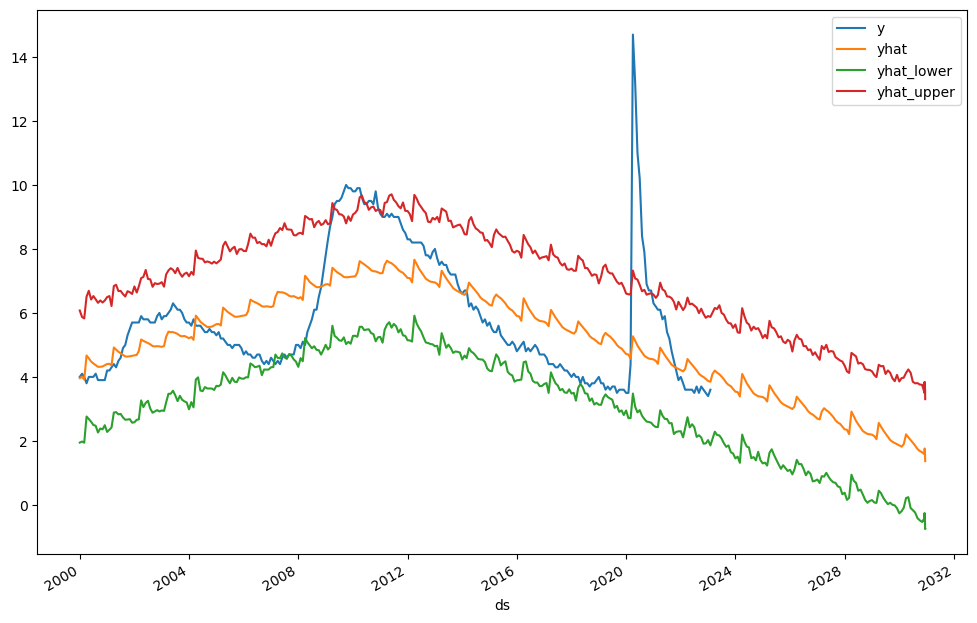

In [50]:
preds[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot(figsize=(12,8))

In [51]:
rmse = np.sqrt(mean_squared_error(preds['y'][0:j], preds['yhat'][0:j]))
print(rmse)

1.5531974254355996


In [52]:
preds.reset_index(inplace=True)
preds

,ds,y,yhat,yhat_lower,yhat_upper
0,2000-01-01,4.0,3.963624,1.947457,6.076294
1,2000-02-01,4.1,4.002104,1.980399,5.871680
2,2000-03-01,4.0,3.914145,1.943349,5.829153
3,2000-04-01,3.8,4.669458,2.762068,6.508322
4,2000-05-01,4.0,4.580645,2.684485,6.692082
...,...,...,...,...,...
379,2030-12-09,NaN,1.678309,-0.326796,3.754271
380,2030-12-10,NaN,1.618488,-0.516269,3.640304
381,2030-12-11,NaN,1.545275,-0.543148,3.615050
382,2030-12-12,NaN,1.460778,-0.757716,3.556228


In [53]:
preds.to_excel("FBProhet_Results.xlsx", index=False)